In [1]:
import sys,os
import workflow.extrude
import numpy as np
from matplotlib import pyplot as plt


# of x and z elemets:  101 ,  101
# of cells:  100


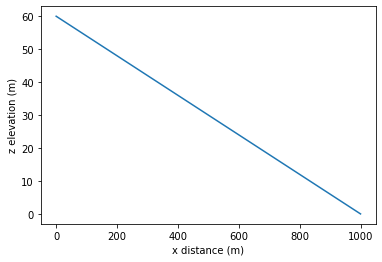

In [2]:
# 1 km long hillslope, 10% slope
x = np.linspace(0,1000,101)
z = 60 - 0.06*x
print('# of x and z elemets: ',len(x),', ',len(z))
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = workflow.extrude.Mesh2D.from_Transect(x,z)
print('# of cells: ', m2.num_cells())


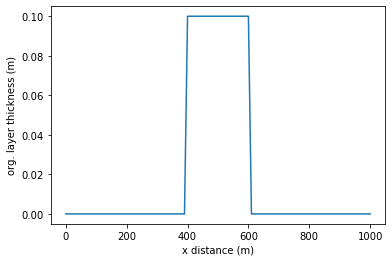

In [3]:
# Changing organic layer thickness 
def organic_thickness(x):
    """This function is the thickness of the layer we want to vary"""
    if x < 400:
        thickness = 0.
    elif (x > 600):
        thickness = 0.
    else:
        thickness = 0.1
    return thickness

org_layer_thickness = np.array([organic_thickness(xx) for xx in m2.coords[:,0]])
plt.plot(x, org_layer_thickness[0:101]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');


In [4]:
# preparing layer extrusion data for meshing_ats
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical unit to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth = []  # used later to get the mat ids right, just for bookkeeping
        
# here we will only use 1 cell per layer, so layer thickness = dz.
# We will also telescope the mesh, starting at 1cm grid cell and growing it larger in each layer.
dz = .05
current_depth = 0

for i in range(2):
    layer_data.append(dz)
    layer_types.append("constant")
    layer_ncells.append(1)
    current_depth += dz
    layer_depth.append(current_depth)

i = 0
while dz < 2:
    if i<=20:            #organic
        dz *= 1.2

    if dz < 2:
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        current_depth += dz
        layer_depth.append(current_depth)
        i += 1
    
# now add in a bunch of cells to reach 45 m, of equal dz that is ~2m.
num_of_layers=len(layer_data)
layer_types.append('constant')
layer_data.append(50 - sum(layer_data))  # note sum(layer_data) == the total mesh thickness at this point
layer_ncells.append(int(np.floor(layer_data[-1]/dz)))
layer_depth.append(50)


In [5]:
layer_ids = np.ones((100,len(layer_types)), 'i')
print(layer_data)
print(layer_depth)

[0.05, 0.05, 0.06, 0.072, 0.08639999999999999, 0.10367999999999998, 0.12441599999999997, 0.14929919999999997, 0.17915903999999996, 0.21499084799999996, 0.2579890175999999, 0.3095868211199999, 0.37150418534399987, 0.44580502241279985, 0.5349660268953598, 0.6419592322744317, 0.7703510787293181, 0.9244212944751816, 1.1093055533702179, 1.3311666640442614, 1.5973999968531136, 1.9168799962237362, 38.69872002265758]
[0.05, 0.1, 0.16, 0.23199999999999998, 0.31839999999999996, 0.42207999999999996, 0.5464959999999999, 0.6957951999999998, 0.8749542399999998, 1.0899450879999997, 1.3479341055999996, 1.6575209267199995, 2.0290251120639993, 2.4748301344767993, 3.009796161372159, 3.6517553936465905, 4.4221064723759085, 5.34652776685109, 6.455833320221308, 7.78699998426557, 9.384399981118683, 11.30127997734242, 50]


In [6]:
layer_ids.shape

(100, 23)

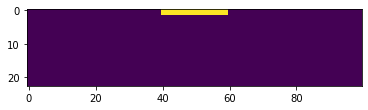

In [7]:
layer_ids[:] = 101
layer_ids[40:60, 0:2] = 102
plt.imshow(layer_ids.transpose())

In [9]:
m3 = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_ids.transpose())

In [11]:
m3.write_exodus('impervious_hillslope.exo')



You are using exodus.py v 1.13 (seacas-beta), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: impervious_hillslope.exo
Closing exodus file: impervious_hillslope.exo
